In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hys
import tkinter.filedialog as tkf
import ipywidgets as pyw

In [ ]:
%matplotlib inline

In [10]:
num_split = 2
adr = []
num_adr = []
for i in range(num_split):
    temp = tkf.askopenfilenames()
    num_adr.append(len(temp))
    adr.append(temp)
print(num_adr)

[2, 2]


In [11]:
data_by_split = []
data_flat = []
data_flat_by_split = []
data_shape = []
for i in range(num_split):
    temp = []
    temp_shape = []
    temp_flat = []
    for path in adr[i]:
        tmp = hys.load(path).data
        temp.append(tmp)
        temp_shape.append(tmp.shape)
        temp_flat.extend(tmp.reshape(-1, tmp.shape[2]).tolist())
        data_flat.extend(tmp.reshape(-1, tmp.shape[2]).tolist())
    data_by_split.append(temp)
    data_shape.append(temp_shape)
    data_flat_by_split.append(temp_flat)

In [12]:
data_flat = np.asarray(data_flat)
print(data_flat.shape)
data_shape = np.asarray(data_shape)
print(data_shape.shape)
print(np.unique(data_shape[:, :, 2]))
s_dim = np.min(data_shape[:, :, 2])
print(s_dim)

(52390, 91)
(2, 2, 3)
[91]
91


In [13]:
radial_var_sum = []
for arr in data_by_split:
    temp = []
    for img in arr:
        temp.append(np.mean(img, axis=(0, 1)))
    radial_var_sum.append(temp)

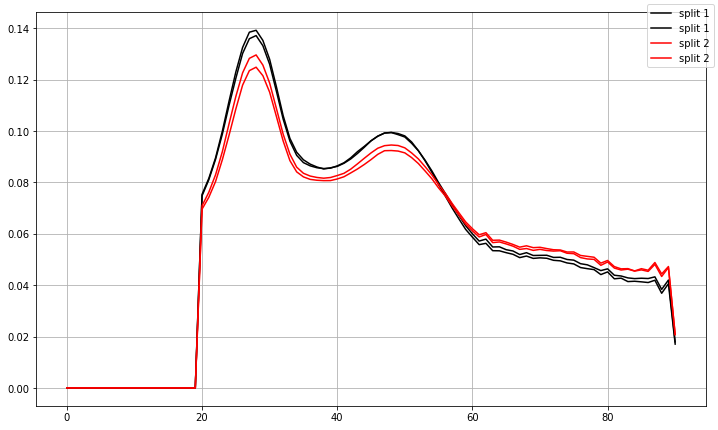

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
linstyles = ["k-", "r-", "b-", "g-", "p-"]
for i in range(num_split):
    for line in radial_var_sum[i]:
        ax.plot(line, linstyles[i], label="split %d"%(i+1))
ax.grid()
fig.legend()
fig.tight_layout()
plt.show()

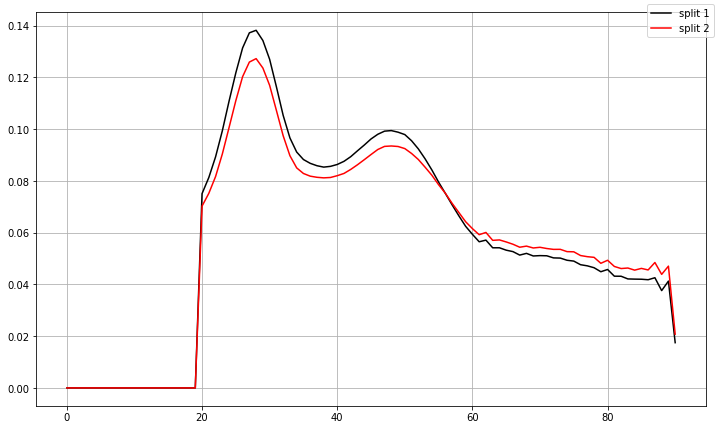

In [15]:
radial_var_split = []
for i in range(num_split):
    radial_var_split.append(np.mean(radial_var_sum[i], axis=0))
    
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(num_split):
    ax.plot(radial_var_split[i], linstyles[i], label="split %d"%(i+1))
ax.grid()
fig.legend()
fig.tight_layout()
plt.show()

In [18]:
%matplotlib qt
binsize = 500
colors = ["black", "red", "blue", "green", "purple"]
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 6))
fig2, ax2 = plt.subplots(num_split, data_shape.shape[1], figsize=(15, 15))

def var_selector(r_range, var_range):
    r1 = r_range[0]
    r2 = r_range[1]
    v1 = var_range[0]
    v2 = var_range[1]
    ax1[0].cla()
    ax1[1].cla()
    for i in range(num_split):
        ax1[0].plot(radial_var_split[i], linstyles[i], label="split %d"%(i+1))
        ax1[1].hist(np.array(data_flat_by_split[i])[:, r1:(r2+1)].flatten(), bins=binsize, 
                    color=colors[i], alpha=0.6-0.1*i, label="split %d"%(i+1), density=True)
        
        for j in range(data_shape.shape[1]):
            img = np.array(data_by_split[i][j])[:, :, r1:(r2+1)]
            img[np.where(img < v1)] = 0
            img[np.where(img > v2)] = 0
            img[np.where(img != 0)] = 1
            bool_img = np.sum(img, axis=2)
            bool_img = np.divide(bool_img, np.where(bool_img!=0, bool_img, 1))
            ax2[i][j].imshow(bool_img, cmap="afmhot")
            ax2[i][j].axis("off")
            ax2[i][j].set_title("%.2f %%"%(np.sum(bool_img)*100/(img.shape[0]*img.shape[1])))
            
    ax1[0].fill_between([r1, r2], np.max(radial_var_split), alpha=0.5, color="orange")
    ax1[0].grid()
    ax1[0].legend()
    ax1[1].fill_between([v1, v2], ax1[1].get_ylim()[1], alpha=0.5, color="orange")
    ax1[1].grid()
    ax1[1].legend()
    
    fig1.canvas.draw()
    fig2.canvas.draw()
    fig1.tight_layout()
    fig2.tight_layout()
    
    
range_widget = pyw.IntRangeSlider(value=[26, 29], min=0, max=s_dim-1, step=1)
range_widget_2 = pyw.FloatRangeSlider(value=[np.max(data_flat)*0.3, np.max(data_flat)*0.5], 
                                      min=np.min(data_flat), max=np.max(data_flat), step=0.01)
pyw.interact(var_selector, r_range=range_widget, var_range=range_widget_2)
plt.show()

interactive(children=(IntRangeSlider(value=(26, 29), description='r_range', max=90), FloatRangeSlider(value=(0…